In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange
from tqdm import tqdm

# Setting Constants
x_0 = 0
y_0 = 0
t_i = 0
t_f = 8

mass = 1
steps = 150  # Reduced from 800 - fewer points to update
numb_paths = 1000

times = np.linspace(t_i, t_f, steps)
dt = times[1] - times[0]

# Position generating function
def Pos_Gen(x0, xN, Steps, dt):
    path = np.zeros(Steps)
    path[0] = x0

    for i in range(1, Steps):
        path[i] = path[i-1] + np.random.normal(0, np.sqrt(dt))

    # shift so endpoint is exactly xN
    path += np.linspace(0, xN - path[-1], Steps)
    return path

# Vectorized interior point update
def metropolis_path_update_vectorised(paths, times, mass, potential, i, sigma_prop):
    dt = times[1] - times[0]

    x_old = paths[:, i]
    x_prev = paths[:, i - 1]
    x_next = paths[:, i + 1]

    x_new = x_old + np.random.normal(0, sigma_prop, size=x_old.shape)

    # Kinetic term change
    dS_kin = (mass / (2*dt)) * (
        (x_new - x_prev)**2 + (x_next - x_new)**2
        - (x_old - x_prev)**2 - (x_next - x_old)**2
    )

    # Potential term change
    x_mid_prev_old = 0.5 * (x_prev + x_old)
    x_mid_next_old = 0.5 * (x_old + x_next)
    x_mid_prev_new = 0.5 * (x_prev + x_new)
    x_mid_next_new = 0.5 * (x_new + x_next)

    dS_pot = dt * (
        potential(x_mid_prev_new) + potential(x_mid_next_new)
        - potential(x_mid_prev_old) - potential(x_mid_next_old)
    )

    dS = dS_kin + dS_pot

    accept = np.random.rand(len(x_old)) < np.exp(-dS)
    paths[accept, i] = x_new[accept]

    return np.mean(accept)

# NEW: Endpoint update function
def metropolis_endpoint_update_vectorised(paths, times, mass, potential, sigma_prop):
    """
    Vectorised Metropolis update for endpoint (last point) of all paths.
    """
    dt = times[1] - times[0]
    i = paths.shape[1] - 1  # last point

    x_old = paths[:, i]
    x_prev = paths[:, i-1]

    # symmetric proposal
    x_new = x_old + np.random.normal(0, sigma_prop, size=x_old.shape)

    # Kinetic term change (only one neighbor)
    dS_kin = (mass / (2*dt)) * ((x_new - x_prev)**2 - (x_old - x_prev)**2)

    # Potential at midpoint between second-to-last and endpoint
    x_mid_old = 0.5 * (x_prev + x_old)
    x_mid_new = 0.5 * (x_prev + x_new)
    dS_pot_mid = dt * (potential(x_mid_new) - potential(x_mid_old))

    # CRITICAL FIX: Also include potential at the endpoint itself (half weight)
    dS_pot_end = 0.5 * dt * (potential(x_new) - potential(x_old))

    dS = dS_kin + dS_pot_mid + dS_pot_end

    accept = np.random.rand(len(x_old)) < np.exp(-dS)
    paths[accept, i] = x_new[accept]

    return np.mean(accept)

# Full sweep function - BETTER optimization
def metropolis_sweep_vectorised(paths, times, mass, potential, sigma_prop, n_interior_updates=5):
    """
    Do a partial sweep: update only n_interior_updates random interior points
    plus always update the endpoint.
    """
    n_steps = paths.shape[1]

    # Randomly select which interior points to update
    interior_indices = np.random.choice(range(1, n_steps-1), size=n_interior_updates, replace=False)

    acceptances = []
    for i in interior_indices:
        acc = metropolis_path_update_vectorised(paths, times, mass, potential, i, sigma_prop)
        acceptances.append(acc)

    # Always update endpoint
    endpoint_accept = metropolis_endpoint_update_vectorised(
        paths, times, mass, potential, sigma_prop
    )

    return np.mean(acceptances) if acceptances else 0.0, endpoint_accept

# Potentials

In [53]:
# Potential
def x_potential(x):
    return 1/2 * x**2

def y_potential(x):
    return 1000 * x**4

# X-Dimension Sampling

Thermalizing...


Thermalising:  30%|███       | 151/500 [00:00<00:00, 752.61it/s]

Endpoint acceptance ≈ 0.409
Endpoint acceptance ≈ 0.424


Thermalising:  71%|███████   | 354/500 [00:00<00:00, 790.62it/s]

Endpoint acceptance ≈ 0.402
Endpoint acceptance ≈ 0.454


Thermalising: 100%|██████████| 500/500 [00:00<00:00, 769.14it/s]


Endpoint acceptance ≈ 0.423

Sampling...


Sampling:   1%|          | 56/5000 [00:00<00:06, 775.42it/s]

Endpoint acceptance ≈ 0.429


Sampling:   3%|▎         | 156/5000 [00:00<00:06, 807.05it/s]

Endpoint acceptance ≈ 0.449


Sampling:   5%|▌         | 255/5000 [00:00<00:06, 766.29it/s]

Endpoint acceptance ≈ 0.449


Sampling:   7%|▋         | 355/5000 [00:00<00:05, 785.48it/s]

Endpoint acceptance ≈ 0.442


Sampling:   9%|▉         | 455/5000 [00:00<00:05, 769.94it/s]

Endpoint acceptance ≈ 0.443


Sampling:  11%|█         | 554/5000 [00:00<00:05, 769.75it/s]

Endpoint acceptance ≈ 0.471


Sampling:  13%|█▎        | 655/5000 [00:00<00:05, 812.05it/s]

Endpoint acceptance ≈ 0.438


Sampling:  15%|█▌        | 755/5000 [00:00<00:05, 818.17it/s]

Endpoint acceptance ≈ 0.437


Sampling:  17%|█▋        | 855/5000 [00:01<00:05, 788.28it/s]

Endpoint acceptance ≈ 0.427


Sampling:  19%|█▉        | 956/5000 [00:01<00:04, 822.56it/s]

Endpoint acceptance ≈ 0.420


Sampling:  21%|██        | 1055/5000 [00:01<00:05, 724.59it/s]

Endpoint acceptance ≈ 0.467


Sampling:  23%|██▎       | 1156/5000 [00:01<00:04, 796.29it/s]

Endpoint acceptance ≈ 0.425


Sampling:  25%|██▌       | 1253/5000 [00:01<00:06, 612.83it/s]

Endpoint acceptance ≈ 0.433


Sampling:  27%|██▋       | 1352/5000 [00:01<00:04, 756.39it/s]

Endpoint acceptance ≈ 0.428


Sampling:  29%|██▉       | 1454/5000 [00:01<00:04, 801.16it/s]

Endpoint acceptance ≈ 0.454


Sampling:  31%|███       | 1557/5000 [00:02<00:03, 862.13it/s]

Endpoint acceptance ≈ 0.427


Sampling:  33%|███▎      | 1656/5000 [00:02<00:04, 774.54it/s]

Endpoint acceptance ≈ 0.429


Sampling:  35%|███▌      | 1754/5000 [00:02<00:04, 778.59it/s]

Endpoint acceptance ≈ 0.414


Sampling:  37%|███▋      | 1854/5000 [00:02<00:04, 779.01it/s]

Endpoint acceptance ≈ 0.408


Sampling:  39%|███▉      | 1955/5000 [00:02<00:03, 761.57it/s]

Endpoint acceptance ≈ 0.470


Sampling:  41%|████      | 2056/5000 [00:02<00:03, 820.30it/s]

Endpoint acceptance ≈ 0.438


Sampling:  43%|████▎     | 2154/5000 [00:02<00:03, 767.94it/s]

Endpoint acceptance ≈ 0.429


Sampling:  45%|████▌     | 2255/5000 [00:02<00:03, 784.93it/s]

Endpoint acceptance ≈ 0.402


Sampling:  47%|████▋     | 2355/5000 [00:03<00:03, 805.96it/s]

Endpoint acceptance ≈ 0.455


Sampling:  49%|████▉     | 2453/5000 [00:03<00:03, 820.75it/s]

Endpoint acceptance ≈ 0.431


Sampling:  51%|█████     | 2555/5000 [00:03<00:03, 762.45it/s]

Endpoint acceptance ≈ 0.414


Sampling:  53%|█████▎    | 2655/5000 [00:03<00:02, 784.64it/s]

Endpoint acceptance ≈ 0.424


Sampling:  55%|█████▌    | 2754/5000 [00:03<00:02, 812.56it/s]

Endpoint acceptance ≈ 0.461


Sampling:  57%|█████▋    | 2855/5000 [00:03<00:02, 734.20it/s]

Endpoint acceptance ≈ 0.430


Sampling:  59%|█████▉    | 2954/5000 [00:03<00:02, 810.26it/s]

Endpoint acceptance ≈ 0.444


Sampling:  61%|██████    | 3055/5000 [00:03<00:02, 744.02it/s]

Endpoint acceptance ≈ 0.404


Sampling:  63%|██████▎   | 3156/5000 [00:04<00:02, 789.63it/s]

Endpoint acceptance ≈ 0.403


Sampling:  65%|██████▌   | 3256/5000 [00:04<00:02, 782.35it/s]

Endpoint acceptance ≈ 0.442


Sampling:  67%|██████▋   | 3354/5000 [00:04<00:02, 748.28it/s]

Endpoint acceptance ≈ 0.464


Sampling:  69%|██████▉   | 3455/5000 [00:04<00:01, 789.84it/s]

Endpoint acceptance ≈ 0.425


Sampling:  71%|███████   | 3555/5000 [00:04<00:01, 778.85it/s]

Endpoint acceptance ≈ 0.428


Sampling:  73%|███████▎  | 3651/5000 [00:04<00:01, 767.46it/s]

Endpoint acceptance ≈ 0.427


Sampling:  75%|███████▌  | 3752/5000 [00:04<00:01, 794.98it/s]

Endpoint acceptance ≈ 0.452


Sampling:  77%|███████▋  | 3854/5000 [00:05<00:01, 746.66it/s]

Endpoint acceptance ≈ 0.423


Sampling:  79%|███████▉  | 3957/5000 [00:05<00:01, 774.00it/s]

Endpoint acceptance ≈ 0.417


Sampling:  81%|████████  | 4053/5000 [00:05<00:01, 743.15it/s]

Endpoint acceptance ≈ 0.424


Sampling:  83%|████████▎ | 4145/5000 [00:05<00:01, 700.82it/s]

Endpoint acceptance ≈ 0.432


Sampling:  85%|████████▍ | 4239/5000 [00:05<00:01, 685.04it/s]

Endpoint acceptance ≈ 0.413


Sampling:  87%|████████▋ | 4341/5000 [00:05<00:01, 612.75it/s]

Endpoint acceptance ≈ 0.448


Sampling:  89%|████████▉ | 4451/5000 [00:05<00:00, 763.74it/s]

Endpoint acceptance ≈ 0.420


Sampling:  91%|█████████ | 4553/5000 [00:05<00:00, 763.68it/s]

Endpoint acceptance ≈ 0.424


Sampling:  93%|█████████▎| 4655/5000 [00:06<00:00, 791.78it/s]

Endpoint acceptance ≈ 0.430


Sampling:  95%|█████████▌| 4753/5000 [00:06<00:00, 794.16it/s]

Endpoint acceptance ≈ 0.445


Sampling:  97%|█████████▋| 4853/5000 [00:06<00:00, 788.06it/s]

Endpoint acceptance ≈ 0.457


Sampling:  99%|█████████▉| 4955/5000 [00:06<00:00, 760.27it/s]

Endpoint acceptance ≈ 0.425


Sampling: 100%|██████████| 5000/5000 [00:06<00:00, 763.46it/s]



------ Results ------
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000
Standard deviation: 0.6979 (expected ≈ 0.707)
Root mean square: 0.6990 (expected ≈ 0.707)


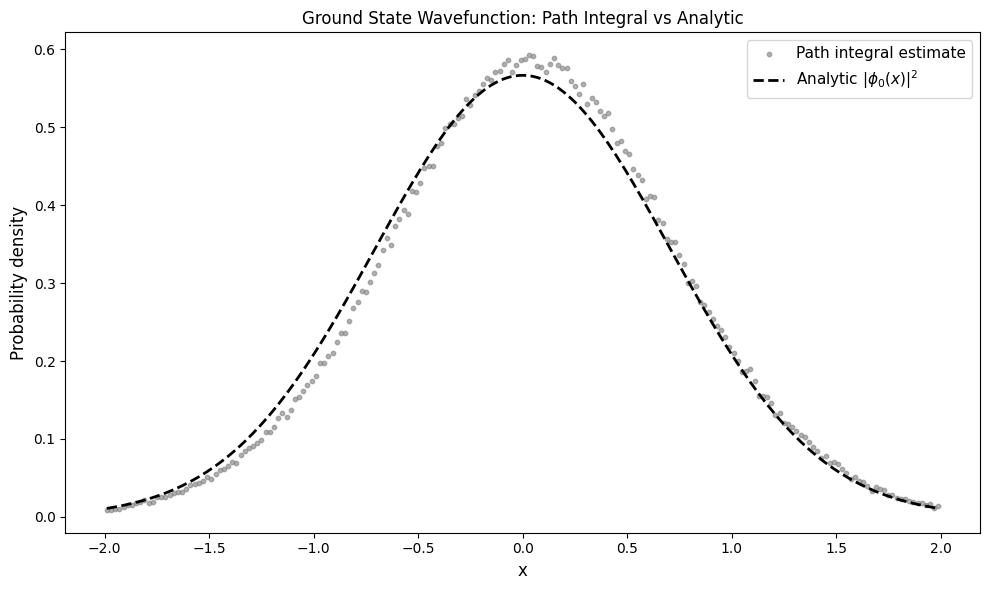

In [52]:
# Initialize paths (Brownian bridge from 0 to 0)
paths_x = np.array([
    Pos_Gen(0.0, 0.0, steps, dt)
    for _ in range(numb_paths)
])

C = 2.5
mid = paths_x.shape[1] // 2
thin = 10
sigma_prop = C * np.sqrt(dt)

# Thermalization
print("Thermalizing...")
for sweep in trange(500, desc="Thermalising", mininterval=0):
    acceptances, endpoint_accept = metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if sweep % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

# Sampling
print("\nSampling...")
samples = []

for k in trange(5000, desc="Sampling", mininterval=0):
    acceptances, endpoint_accept = metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if k % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

    if k % thin == 0:
        samples.append(paths_x[:, -1].copy())

samples = np.concatenate(samples)

# Compute PDF
x_bins = np.linspace(-2, 2, 201)
pdf_unnormalised_x, bin_edges_x = np.histogram(samples, bins=x_bins)

x_centres = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])
dx = np.diff(x_bins)[0]

pdf_x = pdf_unnormalised_x / np.sum(pdf_unnormalised_x * dx)

# Analytic PDF
phi_sq_analytic = (1 / np.sqrt(np.pi)) * np.exp(-x_centres ** 2)
phi_sq_analytic /= np.sum(phi_sq_analytic * dx)

# Statistics
mean_square = np.mean(samples**2)
rms = np.sqrt(mean_square)
std = np.std(samples)

print("\n------ Results ------")
print(f"Numerical PDF area: {np.sum(pdf_x * dx):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic * dx):.5f}")
print(f"Standard deviation: {std:.4f} (expected ≈ 0.707)")
print(f"Root mean square: {rms:.4f} (expected ≈ 0.707)")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x_centres, pdf_x, label='Path integral estimate', s=10, alpha=0.6, color = 'grey')
plt.plot(x_centres, phi_sq_analytic, 'black',linestyle = '--', linewidth=2, label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x', fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.legend(fontsize=11)
plt.title('Ground State Wavefunction: Path Integral vs Analytic')

plt.tight_layout()
plt.show()

# Y-Dimension

Thermalizing...


Thermalising:   0%|          | 0/500 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_3268\1045580232.py:60: RuntimeWarning: overflow encountered in exp
  accept = np.random.rand(len(x_old)) < np.exp(-dS)
Thermalising:  19%|█▉        | 94/500 [00:00<00:00, 478.65it/s]

Endpoint acceptance ≈ 0.320


Thermalising:  40%|███▉      | 198/500 [00:00<00:00, 494.05it/s]

Endpoint acceptance ≈ 0.378


Thermalising:  60%|██████    | 300/500 [00:00<00:00, 495.69it/s]

Endpoint acceptance ≈ 0.331


Thermalising:  80%|████████  | 400/500 [00:00<00:00, 488.03it/s]

Endpoint acceptance ≈ 0.359


Thermalising: 100%|██████████| 500/500 [00:01<00:00, 492.74it/s]

Endpoint acceptance ≈ 0.341


Thermalising: 100%|██████████| 500/500 [00:01<00:00, 485.62it/s]



Sampling...


Sampling:   2%|▏         | 99/5000 [00:00<00:09, 504.98it/s]

Endpoint acceptance ≈ 0.345


Sampling:   4%|▍         | 197/5000 [00:00<00:09, 503.89it/s]

Endpoint acceptance ≈ 0.370


Endpoint acceptance ≈ 0.362


Endpoint acceptance ≈ 0.366


Sampling:  10%|█         | 500/5000 [00:01<00:08, 503.11it/s]

Endpoint acceptance ≈ 0.359


Sampling:  12%|█▏        | 600/5000 [00:01<00:08, 501.68it/s]

Endpoint acceptance ≈ 0.323


Sampling:  14%|█▍        | 700/5000 [00:01<00:08, 491.95it/s]

Endpoint acceptance ≈ 0.341


Sampling:  16%|█▌        | 800/5000 [00:01<00:08, 504.61it/s]

Endpoint acceptance ≈ 0.382


Sampling:  18%|█▊        | 900/5000 [00:01<00:08, 502.26it/s]

Endpoint acceptance ≈ 0.343
Endpoint acceptance ≈ 0.330


Sampling:  22%|██▏       | 1094/5000 [00:02<00:08, 483.10it/s]

Endpoint acceptance ≈ 0.330


Sampling:  24%|██▍       | 1189/5000 [00:02<00:09, 392.08it/s]

Endpoint acceptance ≈ 0.372


Sampling:  26%|██▌       | 1298/5000 [00:02<00:07, 504.02it/s]

Endpoint acceptance ≈ 0.376


Sampling:  28%|██▊       | 1400/5000 [00:02<00:07, 506.42it/s]

Endpoint acceptance ≈ 0.344


Sampling:  30%|███       | 1500/5000 [00:03<00:06, 515.61it/s]

Endpoint acceptance ≈ 0.355


Sampling:  32%|███▏      | 1596/5000 [00:03<00:07, 439.95it/s]

Endpoint acceptance ≈ 0.365


Sampling:  34%|███▍      | 1694/5000 [00:03<00:07, 454.41it/s]

Endpoint acceptance ≈ 0.353


Sampling:  36%|███▌      | 1794/5000 [00:03<00:06, 497.80it/s]

Endpoint acceptance ≈ 0.353


Sampling:  38%|███▊      | 1900/5000 [00:03<00:06, 484.34it/s]

Endpoint acceptance ≈ 0.359


Sampling:  40%|███▉      | 1998/5000 [00:04<00:05, 500.41it/s]

Endpoint acceptance ≈ 0.348


Sampling:  42%|████▏     | 2099/5000 [00:04<00:05, 514.71it/s]

Endpoint acceptance ≈ 0.336


Sampling:  44%|████▍     | 2200/5000 [00:04<00:05, 500.77it/s]

Endpoint acceptance ≈ 0.361


Sampling:  46%|████▌     | 2300/5000 [00:04<00:05, 499.41it/s]

Endpoint acceptance ≈ 0.359


Sampling:  48%|████▊     | 2400/5000 [00:04<00:05, 490.57it/s]

Endpoint acceptance ≈ 0.376


Sampling:  50%|████▉     | 2496/5000 [00:05<00:04, 505.67it/s]

Endpoint acceptance ≈ 0.355


Sampling:  52%|█████▏    | 2600/5000 [00:05<00:04, 491.21it/s]

Endpoint acceptance ≈ 0.344


Sampling:  54%|█████▍    | 2700/5000 [00:05<00:04, 469.22it/s]

Endpoint acceptance ≈ 0.370


Sampling:  56%|█████▌    | 2800/5000 [00:05<00:04, 491.20it/s]

Endpoint acceptance ≈ 0.357


Sampling:  58%|█████▊    | 2901/5000 [00:05<00:04, 425.17it/s]

Endpoint acceptance ≈ 0.357
Endpoint acceptance ≈ 0.352


Endpoint acceptance ≈ 0.352


Sampling:  64%|██████▍   | 3200/5000 [00:06<00:03, 506.63it/s]

Endpoint acceptance ≈ 0.347
Endpoint acceptance ≈ 0.372


Sampling:  68%|██████▊   | 3401/5000 [00:06<00:03, 419.45it/s]

Endpoint acceptance ≈ 0.317
Endpoint acceptance ≈ 0.363


Endpoint acceptance ≈ 0.365


Sampling:  74%|███████▍  | 3698/5000 [00:07<00:02, 446.88it/s]

Endpoint acceptance ≈ 0.340


Sampling:  76%|███████▌  | 3787/5000 [00:07<00:02, 461.75it/s]

Endpoint acceptance ≈ 0.366


Sampling:  78%|███████▊  | 3892/5000 [00:08<00:02, 479.65it/s]

Endpoint acceptance ≈ 0.357


Sampling:  80%|███████▉  | 3996/5000 [00:08<00:01, 504.99it/s]

Endpoint acceptance ≈ 0.338


Sampling:  82%|████████▏ | 4097/5000 [00:08<00:01, 489.82it/s]

Endpoint acceptance ≈ 0.377


Sampling:  84%|████████▍ | 4188/5000 [00:08<00:01, 457.45it/s]

Endpoint acceptance ≈ 0.326


Sampling:  86%|████████▌ | 4298/5000 [00:08<00:01, 507.12it/s]

Endpoint acceptance ≈ 0.339


Sampling:  88%|████████▊ | 4400/5000 [00:09<00:01, 495.64it/s]

Endpoint acceptance ≈ 0.363


Sampling:  90%|█████████ | 4500/5000 [00:09<00:01, 485.92it/s]

Endpoint acceptance ≈ 0.350


Sampling:  92%|█████████▏| 4600/5000 [00:09<00:00, 501.34it/s]

Endpoint acceptance ≈ 0.347


Sampling:  94%|█████████▍| 4700/5000 [00:09<00:00, 502.66it/s]

Endpoint acceptance ≈ 0.335


Sampling:  96%|█████████▌| 4800/5000 [00:09<00:00, 489.39it/s]

Endpoint acceptance ≈ 0.353


Sampling:  98%|█████████▊| 4900/5000 [00:10<00:00, 479.76it/s]

Endpoint acceptance ≈ 0.324


Sampling: 100%|██████████| 5000/5000 [00:10<00:00, 494.23it/s]

Endpoint acceptance ≈ 0.340


Sampling: 100%|██████████| 5000/5000 [00:10<00:00, 484.77it/s]



------ Results ------
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000
Standard deviation: 0.1972 (expected ≈ 0.707)
Root mean square: 0.1972 (expected ≈ 0.707)


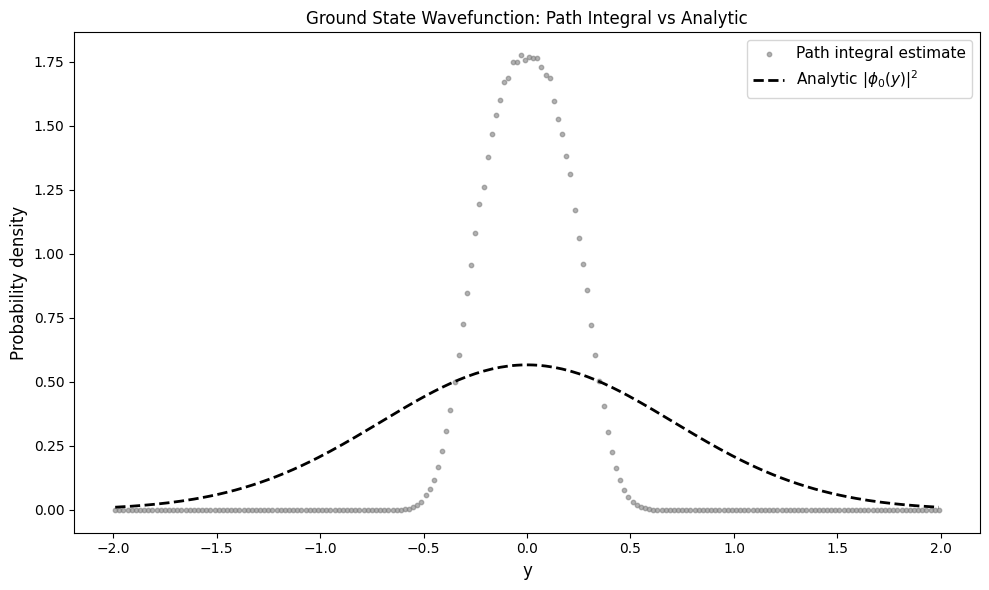

In [55]:
# Initialize paths (Brownian bridge from 0 to 0)
paths_y = np.array([
    Pos_Gen(0.0, 0.0, steps, dt)
    for _ in range(numb_paths)
])

C = 2.5
mid = paths_y.shape[1] // 2
thin = 10
sigma_prop = C * np.sqrt(dt)

# Thermalization
print("Thermalizing...")
for sweep in trange(500, desc="Thermalising", mininterval=0):
    acceptances, endpoint_accept = metropolis_sweep_vectorised(
        paths_y, times, mass, y_potential, sigma_prop
    )

    if sweep % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

# Sampling
print("\nSampling...")
samples_y = []

for k in trange(5000, desc="Sampling", mininterval=0):
    acceptances, endpoint_accept = metropolis_sweep_vectorised(
        paths_y, times, mass, y_potential, sigma_prop
    )

    if k % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

    if k % thin == 0:
        samples_y.append(paths_y[:, -1].copy())

samples_y = np.concatenate(samples_y)

# Compute PDF
y_bins = np.linspace(-2, 2, 201)
pdf_unnormalised_y, bin_edges_y = np.histogram(samples_y, bins=y_bins)

y_centres = 0.5 * (bin_edges_y[1:] + bin_edges_y[:-1])
dy = np.diff(y_bins)[0]

pdf_y = pdf_unnormalised_y / np.sum(pdf_unnormalised_y * dy)

# Analytic PDF
phi_sq_analytic = (1 / np.sqrt(np.pi)) * np.exp(-y_centres ** 2)
phi_sq_analytic /= np.sum(phi_sq_analytic * dy)

# Statistics
mean_square_y = np.mean(samples_y**2)
rms = np.sqrt(mean_square_y)
std = np.std(samples_y)

print("\n------ Results ------")
print(f"Numerical PDF area: {np.sum(pdf_y * dy):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic * dy):.5f}")
print(f"Standard deviation: {std:.4f} (expected ≈ 0.707)")
print(f"Root mean square: {rms:.4f} (expected ≈ 0.707)")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_centres, pdf_y, label='Path integral estimate', s=10, alpha=0.6, color = 'grey')
plt.plot(y_centres, phi_sq_analytic, 'black',linestyle = '--', linewidth=2, label=r'Analytic $|\phi_0(y)|^2$')
plt.xlabel('y', fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.legend(fontsize=11)
plt.title('Ground State Wavefunction: Path Integral vs Analytic')

plt.tight_layout()
plt.show()

# 3D extension

In [58]:
# =========================
# 3D Joint Probability Density P(x,y)
# =========================

# 2D histogram
bins = np.linspace(-2, 2, 101)  # 100x100 bins
pdf_xy, x_edges, y_edges = np.histogram2d(samples, samples_y, bins=[bins, bins])

dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]

# Normalize so total probability = 1
pdf_xy = pdf_xy / np.sum(pdf_xy * dx * dy)

# Create meshgrid for plotting
x_centres = 0.5 * (x_edges[1:] + x_edges[:-1])
y_centres = 0.5 * (y_edges[1:] + y_edges[:-1])
X, Y = np.meshgrid(x_centres, y_centres)

# 3D Surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Transpose pdf_xy so axes match meshgrid
ax.plot_surface(X, Y, pdf_xy.T, cmap='viridis', edgecolor='none')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('Probability density', fontsize=12)
ax.set_title('Joint Probability Density $P(x,y)$', fontsize=14)

plt.tight_layout()
plt.show()


ValueError: x and y must have the same length.

In [59]:
print(len(samples))

500000


In [60]:
print(len(samples_y))

1000
